In [4]:
import kagglehub


path = kagglehub.dataset_download("denkuznetz/food-delivery-time-prediction")

print( path)

/kaggle/input/food-delivery-time-prediction


In [1]:
!pip install catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.2 MB/s eta 0:00:00


In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
from scipy.stats import norm
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')


In [8]:
df = pd.read_csv(path + "/Food_Delivery_Times.csv")

print(f"Shape: {df.shape}")
print(f"Duplicates: {df.duplicated().sum()}")
print(f"Columns: {list(df.columns)}")
print()
print(df.info())
print()
print(df.head())
print("\nTarget variable statistics:")
print(df['Delivery_Time_min'].describe())

Shape: (1000, 9)
Duplicates: 0
Columns: ['Order_ID', 'Distance_km', 'Weather', 'Traffic_Level', 'Time_of_Day', 'Vehicle_Type', 'Preparation_Time_min', 'Courier_Experience_yrs', 'Delivery_Time_min']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Order_ID                1000 non-null   int64  
 1   Distance_km             1000 non-null   float64
 2   Weather                 970 non-null    object 
 3   Traffic_Level           970 non-null    object 
 4   Time_of_Day             970 non-null    object 
 5   Vehicle_Type            1000 non-null   object 
 6   Preparation_Time_min    1000 non-null   int64  
 7   Courier_Experience_yrs  970 non-null    float64
 8   Delivery_Time_min       1000 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 70.4+ KB
None

   Order_ID  Distance_km Weather Traffic_Lev

In [9]:
print("\nFeature Categories Analysis:")
print("Categorical Features:")
categorical_features = ['Weather', 'Traffic_Level', 'Time_of_Day', 'Vehicle_Type']
for feature in categorical_features:
    print(f"  {feature}: {df[feature].value_counts().to_dict()}")


Feature Categories Analysis:
Categorical Features:
  Weather: {'Clear': 470, 'Rainy': 204, 'Foggy': 103, 'Snowy': 97, 'Windy': 96}
  Traffic_Level: {'Medium': 390, 'Low': 383, 'High': 197}
  Time_of_Day: {'Morning': 308, 'Evening': 293, 'Afternoon': 284, 'Night': 85}
  Vehicle_Type: {'Bike': 503, 'Scooter': 302, 'Car': 195}


In [10]:
print("\nNumerical Features:")
numerical_features = ['Distance_km', 'Preparation_Time_min', 'Courier_Experience_yrs']
for feature in numerical_features:
    print(f"  {feature}: mean={df[feature].mean():.2f}, std={df[feature].std():.2f}, range=[{df[feature].min():.1f}, {df[feature].max():.1f}]")

print(f"\nTarget variable (Delivery_Time_min): mean={df['Delivery_Time_min'].mean():.2f}, std={df['Delivery_Time_min'].std():.2f}")

print("\nMissing values:")
missing_summary = df.isnull().sum()
if missing_summary.sum() > 0:
    for col in missing_summary[missing_summary > 0].index:
        print(f'  {col}: {missing_summary[col]} missing values ({missing_summary[col]/len(df)*100:.1f}%)')
else:
    print("  No missing values found!")


Numerical Features:
  Distance_km: mean=10.06, std=5.70, range=[0.6, 20.0]
  Preparation_Time_min: mean=16.98, std=7.20, range=[5.0, 29.0]
  Courier_Experience_yrs: mean=4.58, std=2.91, range=[0.0, 9.0]

Target variable (Delivery_Time_min): mean=56.73, std=22.07

Missing values:
  Weather: 30 missing values (3.0%)
  Traffic_Level: 30 missing values (3.0%)
  Time_of_Day: 30 missing values (3.0%)
  Courier_Experience_yrs: 30 missing values (3.0%)


In [11]:
print("\nHandling missing values...")
original_nulls = df.isnull().sum().sum()



Handling missing values...


In [13]:
# Fill categorical features with mode (most frequent value)
categorical_features = ['Weather', 'Traffic_Level', 'Time_of_Day', 'Vehicle_Type']
for feature in categorical_features:
    if df[feature].isnull().sum() > 0:
        mode_value = df[feature].mode()[0]
        df[feature] = df[feature].fillna(mode_value)
        print(f"  {feature}: filled {df[feature].isnull().sum()} nulls with mode '{mode_value}'")


  Weather: filled 0 nulls with mode 'Clear'
  Traffic_Level: filled 0 nulls with mode 'Medium'
  Time_of_Day: filled 0 nulls with mode 'Morning'


In [14]:
numerical_features = ['Distance_km', 'Preparation_Time_min', 'Courier_Experience_yrs']
for feature in numerical_features:
    if df[feature].isnull().sum() > 0:
        median_value = df[feature].median()
        df[feature] = df[feature].fillna(median_value)
        print(f"  {feature}: filled nulls with median {median_value:.2f}")


  Courier_Experience_yrs: filled nulls with median 5.00


In [15]:
final_nulls = df.isnull().sum().sum()
print(f"\nMissing values: {original_nulls} → {final_nulls} (all handled)")


Missing values: 120 → 0 (all handled)


In [17]:
axes[0, 0].scatter(df["Distance_km"], df["Delivery_Time_min"], alpha=0.6, edgecolor='k')
axes[0, 0].set_title("Distance vs Delivery Time", fontsize=14)
axes[0, 0].set_xlabel("Distance (km)")
axes[0, 0].set_ylabel("Delivery Time (min)")
axes[0, 0].grid(alpha=0.3)

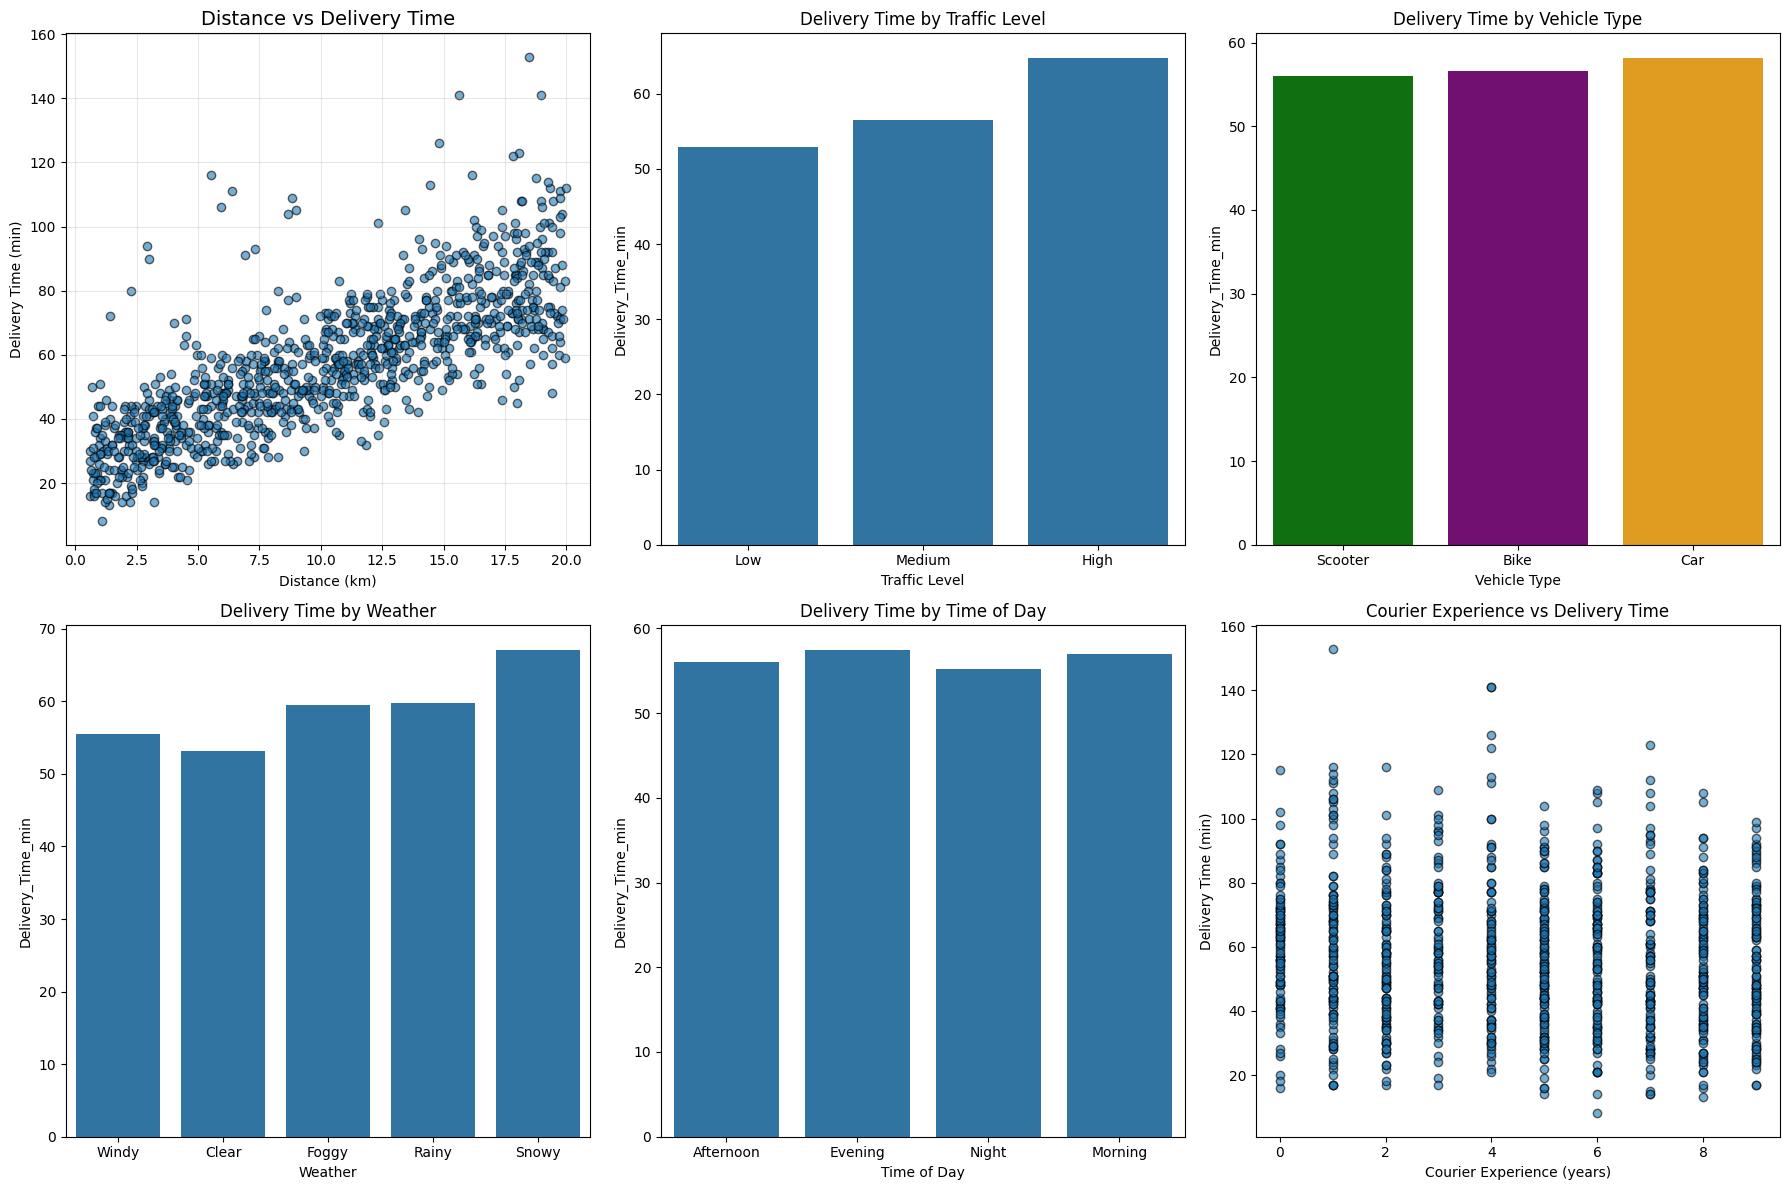

In [20]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Distance vs Delivery Time
axes[0, 0].scatter(df["Distance_km"], df["Delivery_Time_min"], alpha=0.6, edgecolor='k')
axes[0, 0].set_title("Distance vs Delivery Time", fontsize=14)
axes[0, 0].set_xlabel("Distance (km)")
axes[0, 0].set_ylabel("Delivery Time (min)")
axes[0, 0].grid(alpha=0.3)

# Traffic Level impact
sns.barplot(x='Traffic_Level', y='Delivery_Time_min', data=df, ax=axes[0, 1], errorbar=None)
axes[0, 1].set_title("Delivery Time by Traffic Level")
axes[0, 1].set_xlabel("Traffic Level")

# Vehicle Type comparison
sns.barplot(x='Vehicle_Type', y='Delivery_Time_min', data=df, ax=axes[0, 2], errorbar=None,
           palette={'Scooter': "green", 'Bike': "purple", 'Car': 'orange'})
axes[0, 2].set_title("Delivery Time by Vehicle Type")
axes[0, 2].set_xlabel("Vehicle Type")

# Weather impact
sns.barplot(x='Weather', y='Delivery_Time_min', data=df, ax=axes[1, 0], errorbar=None)
axes[1, 0].set_title("Delivery Time by Weather")
axes[1, 0].set_xlabel("Weather")

# Time of Day analysis
sns.barplot(x='Time_of_Day', y='Delivery_Time_min', data=df, ax=axes[1, 1], errorbar=None)
axes[1, 1].set_title("Delivery Time by Time of Day")
axes[1, 1].set_xlabel("Time of Day")

# Courier Experience impact
axes[1, 2].scatter(df["Courier_Experience_yrs"], df["Delivery_Time_min"], alpha=0.6, edgecolor='k')
axes[1, 2].set_title("Courier Experience vs Delivery Time")
axes[1, 2].set_xlabel("Courier Experience (years)")
axes[1, 2].set_ylabel("Delivery Time (min)")

plt.tight_layout()
plt.show()

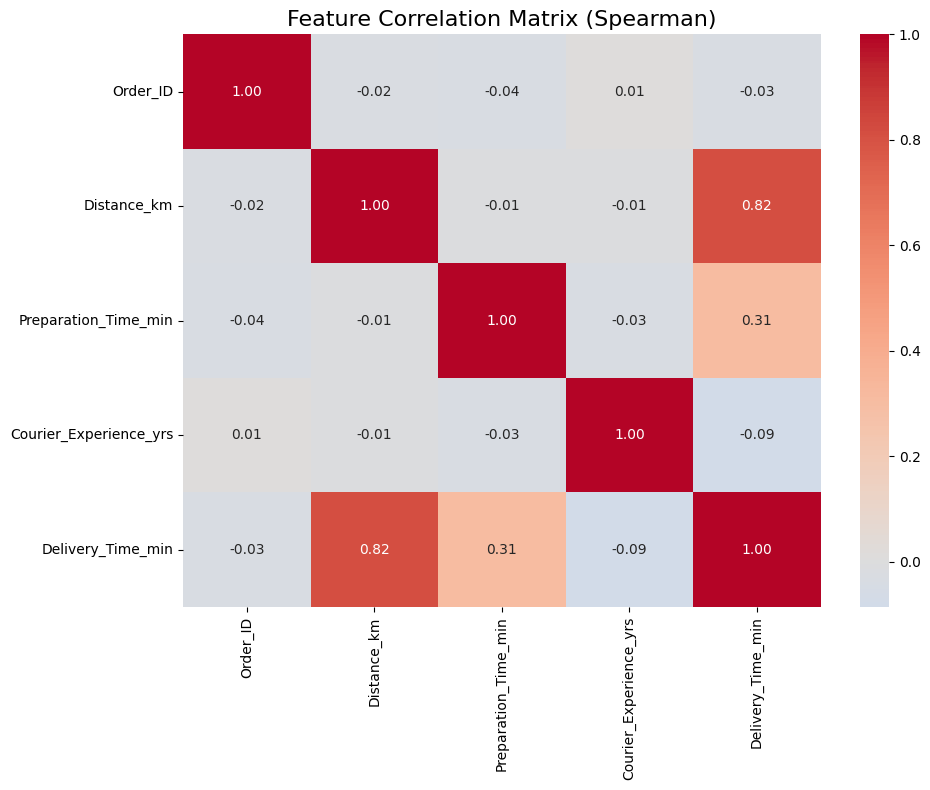

In [21]:
# Correlation analysis
numeric_df = df.select_dtypes(include=['number'])
spearman_corr = numeric_df.corr(method='spearman')

plt.figure(figsize=(10, 8))
sns.heatmap(spearman_corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, center=0)
plt.title('Feature Correlation Matrix (Spearman)', fontsize=16)
plt.tight_layout()
plt.show()

# Prepare data for modeling
df_encoded = pd.get_dummies(df, columns=['Weather', 'Traffic_Level', 'Time_of_Day', 'Vehicle_Type'], drop_first=True)

In [22]:
X = df_encoded.drop(['Order_ID', 'Delivery_Time_min'], axis=1)
y = df_encoded['Delivery_Time_min']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=None)

print(f"\nTraining set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")


Training set shape: (700, 14)
Test set shape: (300, 14)


In [23]:
# Model training and evaluation function
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """Train model and return comprehensive metrics"""
    model.fit(X_train, y_train)

    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Metrics
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

    return {
        'Model': model_name,
        'Train_R2': train_r2,
        'Test_R2': test_r2,
        'Train_MAE': train_mae,
        'Test_MAE': test_mae,
        'Train_RMSE': train_rmse,
        'Test_RMSE': test_rmse,
        'Predictions': y_test_pred
    }


In [24]:
print("Training Linear Regression...")
lr_model = LinearRegression()
lr_results = evaluate_model(lr_model, X_train, X_test, y_train, y_test, "Linear Regression")


Training Linear Regression...


In [25]:
# 2. Random Forest
print("Training Random Forest...")
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_results = evaluate_model(rf_model, X_train, X_test, y_train, y_test, "Random Forest")


Training Random Forest...


In [26]:
# 3. XGBoost with GridSearch
print("Training XGBoost with GridSearch...")
xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='mae', random_state=42)


Training XGBoost with GridSearch...


In [27]:
param_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'min_child_weight': [1, 3]
}

In [28]:
grid_search_xgb = GridSearchCV(xgb_regressor, param_xgb, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric='mae',
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=Non...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.2], 'max_depth': [3, 5, 7],
                         'min_child_weight': [1, 3], 'n_estimators': [100, 200],
                         'subsample': [0.8, 1.0]},
             scoring='neg_mean_absolute_error')

In [29]:
best_xgb = grid_search_xgb.best_estimator_
xgb_results = evaluate_model(best_xgb, X_train, X_test, y_train, y_test, "XGBoost")
print(f"Best XGBoost params: {grid_search_xgb.best_params_}")


Best XGBoost params: {'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


In [30]:
print("Training LightGBM with GridSearch...")
lgb_regressor = lgb.LGBMRegressor(objective='regression', metric='mae', verbose=-1, random_state=42)


Training LightGBM with GridSearch...


In [31]:
param_lgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'num_leaves': [31, 50],
    'subsample': [0.8, 1.0],
    'min_child_weight': [1, 3]
}

grid_search_lgb = GridSearchCV(lgb_regressor, param_lgb, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search_lgb.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=LGBMRegressor(metric='mae', objective='regression',
                                     random_state=42, verbose=-1),
             n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'min_child_weight': [1, 3],
                         'n_estimators': [100, 200], 'num_leaves': [31, 50],
                         'subsample': [0.8, 1.0]},
             scoring='neg_mean_absolute_error')

In [32]:
best_lgb = grid_search_lgb.best_estimator_
lgb_results = evaluate_model(best_lgb, X_train, X_test, y_train, y_test, "LightGBM")
print(f"Best LightGBM params: {grid_search_lgb.best_params_}")


Best LightGBM params: {'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'num_leaves': 31, 'subsample': 0.8}


In [33]:
print("Training CatBoost...")
cat_model = CatBoostRegressor(
    iterations=200,
    learning_rate=0.1,
    depth=6,
    eval_metric='MAE',
    random_seed=42,
    verbose=False
)
cat_results = evaluate_model(cat_model, X_train, X_test, y_train, y_test, "CatBoost")

# Compile results
results_list = [lr_results, rf_results, xgb_results, lgb_results, cat_results]
results_df = pd.DataFrame(results_list)


Training CatBoost...


In [34]:
print("\n" + "="*80)
print("MODEL COMPARISON RESULTS")
print("="*80)
print(results_df[['Model', 'Test_R2', 'Test_MAE', 'Test_RMSE']].round(4))

# Find best model
best_model_idx = results_df['Test_MAE'].idxmin()
best_model_name = results_df.loc[best_model_idx, 'Model']
print(f"\nBest Model: {best_model_name} (Lowest Test MAE: {results_df.loc[best_model_idx, 'Test_MAE']:.4f})")



MODEL COMPARISON RESULTS
               Model  Test_R2  Test_MAE  Test_RMSE
0  Linear Regression   0.8324    6.0162     9.1602
1      Random Forest   0.7945    6.9079    10.1435
2            XGBoost   0.8176    6.2862     9.5559
3           LightGBM   0.8101    6.6081     9.7523
4           CatBoost   0.8140    6.4852     9.6501

Best Model: Linear Regression (Lowest Test MAE: 6.0162)


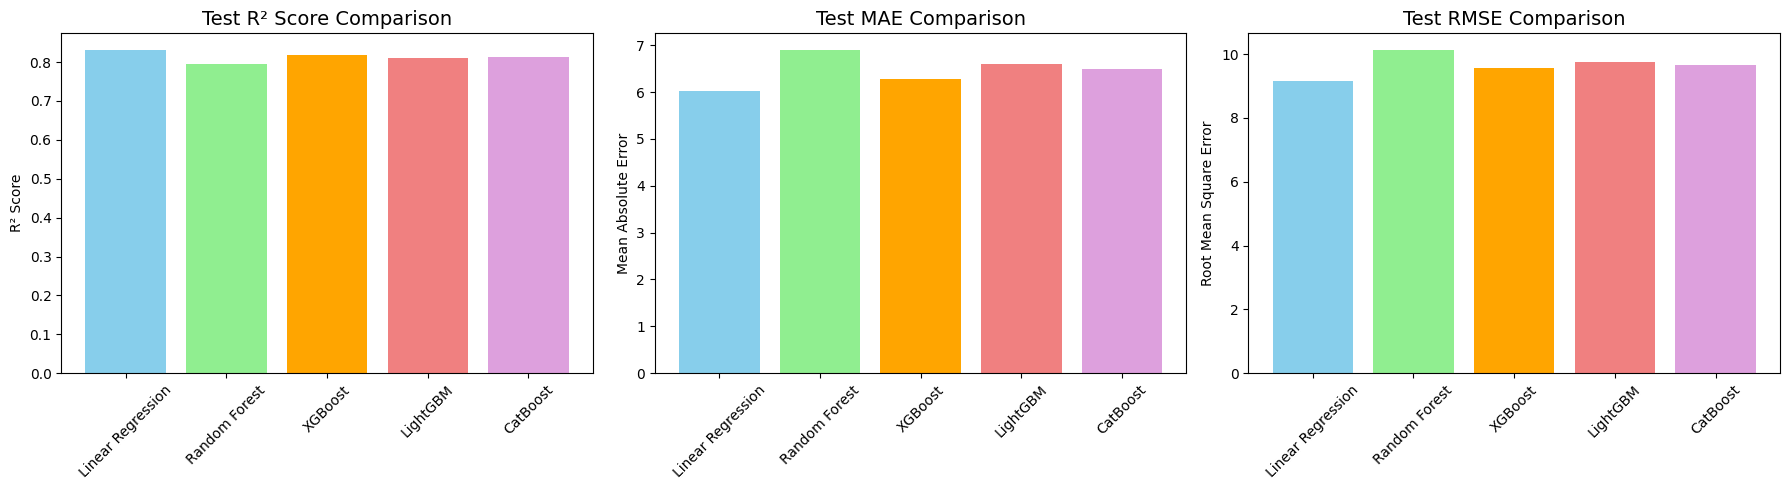

In [35]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# R² comparison
axes[0].bar(results_df['Model'], results_df['Test_R2'], color=['skyblue', 'lightgreen', 'orange', 'lightcoral', 'plum'])
axes[0].set_title('Test R² Score Comparison', fontsize=14)
axes[0].set_ylabel('R² Score')
axes[0].tick_params(axis='x', rotation=45)

# MAE comparison
axes[1].bar(results_df['Model'], results_df['Test_MAE'], color=['skyblue', 'lightgreen', 'orange', 'lightcoral', 'plum'])
axes[1].set_title('Test MAE Comparison', fontsize=14)
axes[1].set_ylabel('Mean Absolute Error')
axes[1].tick_params(axis='x', rotation=45)

# RMSE comparison
axes[2].bar(results_df['Model'], results_df['Test_RMSE'], color=['skyblue', 'lightgreen', 'orange', 'lightcoral', 'plum'])
axes[2].set_title('Test RMSE Comparison', fontsize=14)
axes[2].set_ylabel('Root Mean Square Error')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

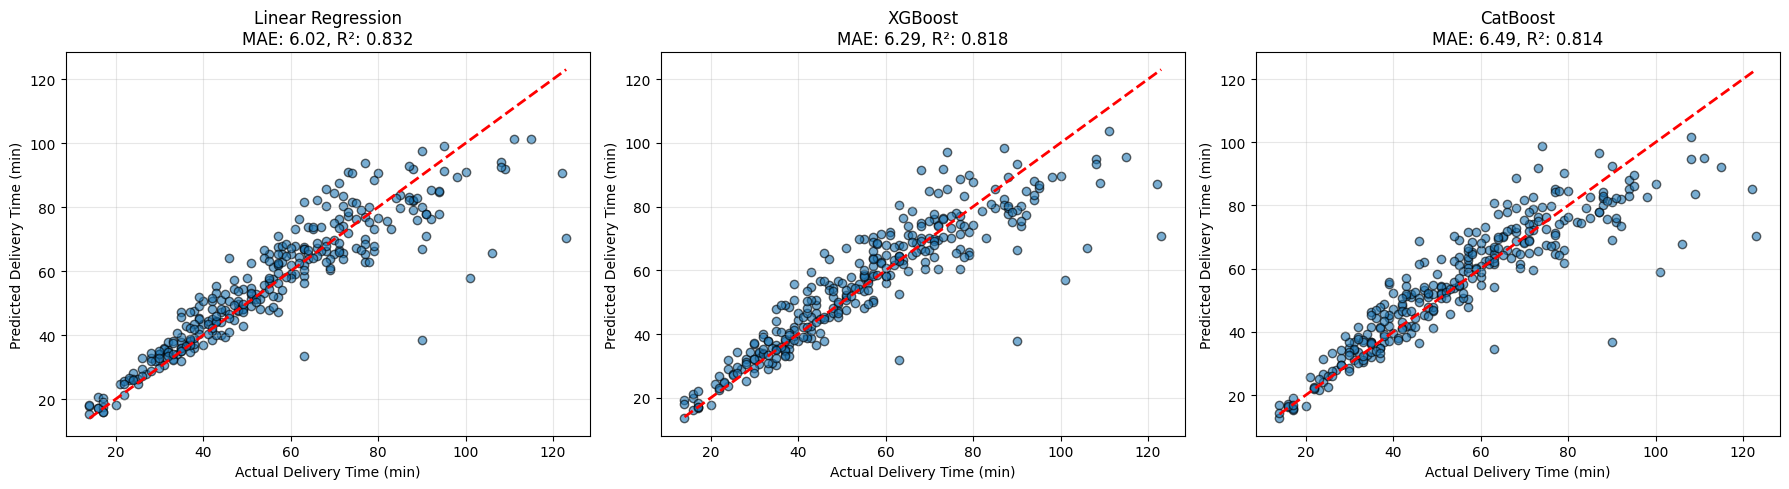

In [36]:
# Prediction vs Actual plots for top 3 models
top_3_models = results_df.nsmallest(3, 'Test_MAE')
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (idx, row) in enumerate(top_3_models.iterrows()):
    y_pred = row['Predictions']
    axes[i].scatter(y_test, y_pred, alpha=0.6, edgecolor='k')
    axes[i].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    axes[i].set_xlabel('Actual Delivery Time (min)')
    axes[i].set_ylabel('Predicted Delivery Time (min)')
    axes[i].set_title(f'{row["Model"]}\nMAE: {row["Test_MAE"]:.2f}, R²: {row["Test_R2"]:.3f}')
    axes[i].grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [38]:
if best_model_name in ['XGBoost', 'LightGBM', 'CatBoost']:
    print(f"\n{best_model_name} Feature Importance Analysis:")

    if best_model_name == 'XGBoost':
        importance_dict = best_xgb.get_booster().get_score(importance_type='weight')
        best_model_obj = best_xgb
    elif best_model_name == 'LightGBM':
        importance_dict = dict(zip(X.columns, best_lgb.feature_importances_))
        best_model_obj = best_lgb
    else:  # CatBoost
        importance_dict = dict(zip(X.columns, cat_model.feature_importances_))
        best_model_obj = cat_model

    # Sort and display top features
    sorted_importance = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)[:10]

    features, importances = zip(*sorted_importance)

    plt.figure(figsize=(10, 6))
    plt.barh(features[::-1], importances[::-1])  # Reverse for top-to-bottom display
    plt.xlabel('Feature Importance')
    plt.title(f'Top 10 Features - {best_model_name}')
    plt.tight_layout()
    plt.show()

    print("Top 10 Most Important Features:")
    for feature, importance in sorted_importance:
        print(f"{feature}: {importance:.4f}")

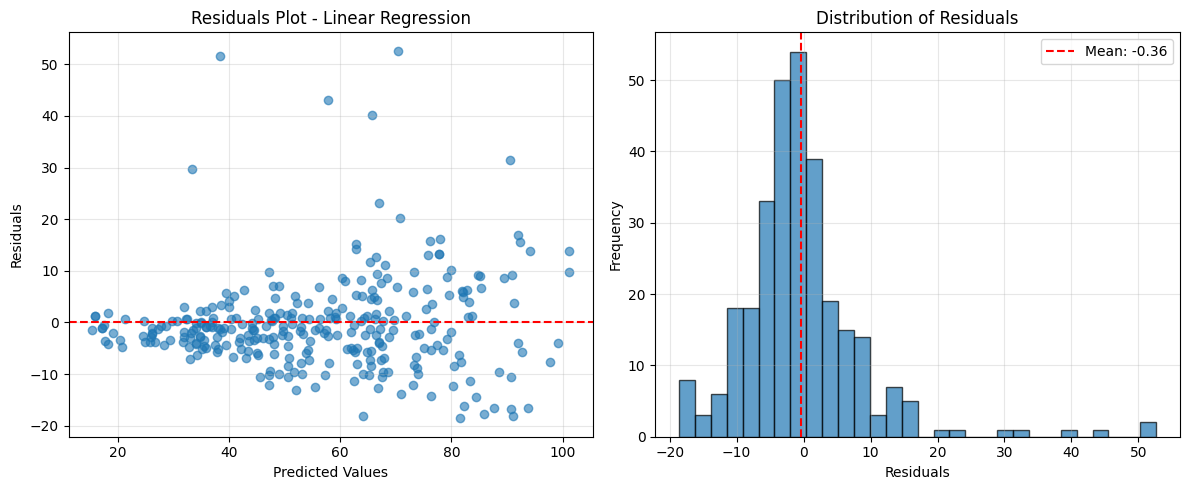

In [39]:
# Error Analysis
best_predictions = results_list[best_model_idx]['Predictions']
residuals = y_test - best_predictions

plt.figure(figsize=(12, 5))

# Residuals plot
plt.subplot(1, 2, 1)
plt.scatter(best_predictions, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title(f'Residuals Plot - {best_model_name}')
plt.grid(alpha=0.3)

# Distribution of residuals
plt.subplot(1, 2, 2)
plt.hist(residuals, bins=30, alpha=0.7, edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.axvline(residuals.mean(), color='r', linestyle='--', label=f'Mean: {residuals.mean():.2f}')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [41]:
print(f"\nResiduals Statistics:")
print(f"Mean: {residuals.mean():.4f}")
print(f"Std: {residuals.std():.4f}")
print(f"Min: {residuals.min():.4f}")
print(f"Max: {residuals.max():.4f}")

# Business Insights
print("\n" + "="*80)
print("KEY BUSINESS INSIGHTS & FEATURE ANALYSIS")
print("="*80)

print("📊 DELIVERY TIME ANALYSIS:")
print(f"   Average delivery time: {df['Delivery_Time_min'].mean():.1f} ± {df['Delivery_Time_min'].std():.1f} minutes")
print(f"   Fastest delivery: {df['Delivery_Time_min'].min():.1f} minutes")
print(f"   Longest delivery: {df['Delivery_Time_min'].max():.1f} minutes")

print(f"\n🌤️  WEATHER IMPACT:")
weather_analysis = df.groupby('Weather')['Delivery_Time_min'].agg(['mean', 'std', 'count']).round(1)
for weather in weather_analysis.index:
    mean_time = weather_analysis.loc[weather, 'mean']
    std_time = weather_analysis.loc[weather, 'std']
    count = weather_analysis.loc[weather, 'count']
    print(f"   {weather:8s}: {mean_time:5.1f} ± {std_time:4.1f} min (n={count:,})")

print(f"\n🚦 TRAFFIC LEVEL IMPACT:")
traffic_analysis = df.groupby('Traffic_Level')['Delivery_Time_min'].agg(['mean', 'std', 'count']).round(1)
for traffic in ['Low', 'Medium', 'High']:  # Ordered by severity
    if traffic in traffic_analysis.index:
        mean_time = traffic_analysis.loc[traffic, 'mean']
        std_time = traffic_analysis.loc[traffic, 'std']
        count = traffic_analysis.loc[traffic, 'count']
        print(f"   {traffic:6s}: {mean_time:5.1f} ± {std_time:4.1f} min (n={count:,})")

print(f"\n🚗 VEHICLE TYPE EFFICIENCY:")
vehicle_analysis = df.groupby('Vehicle_Type')['Delivery_Time_min'].agg(['mean', 'std', 'count']).round(1)
for vehicle in vehicle_analysis.index:
    mean_time = vehicle_analysis.loc[vehicle, 'mean']
    std_time = vehicle_analysis.loc[vehicle, 'std']
    count = vehicle_analysis.loc[vehicle, 'count']
    print(f"   {vehicle:8s}: {mean_time:5.1f} ± {std_time:4.1f} min (n={count:,})")

print(f"\n🕐 TIME OF DAY PATTERNS:")
time_analysis = df.groupby('Time_of_Day')['Delivery_Time_min'].agg(['mean', 'std', 'count']).round(1)
for time_period in ['Morning', 'Afternoon', 'Evening', 'Night']:
    if time_period in time_analysis.index:
        mean_time = time_analysis.loc[time_period, 'mean']
        std_time = time_analysis.loc[time_period, 'std']
        count = time_analysis.loc[time_period, 'count']
        print(f"   {time_period:9s}: {mean_time:5.1f} ± {std_time:4.1f} min (n={count:,})")



Residuals Statistics:
Mean: -0.3588
Std: 9.1685
Min: -18.5907
Max: 52.6454

KEY BUSINESS INSIGHTS & FEATURE ANALYSIS
📊 DELIVERY TIME ANALYSIS:
   Average delivery time: 56.7 ± 22.1 minutes
   Fastest delivery: 8.0 minutes
   Longest delivery: 153.0 minutes

🌤️  WEATHER IMPACT:
   Clear   :  53.2 ± 21.4 min (n=500)
   Foggy   :  59.5 ± 20.9 min (n=103)
   Rainy   :  59.8 ± 22.8 min (n=204)
   Snowy   :  67.1 ± 21.3 min (n=97)
   Windy   :  55.5 ± 21.8 min (n=96)

🚦 TRAFFIC LEVEL IMPACT:
   Low   :  52.9 ± 21.7 min (n=383)
   Medium:  56.5 ± 21.6 min (n=420)
   High  :  64.8 ± 21.9 min (n=197)

🚗 VEHICLE TYPE EFFICIENCY:
   Bike    :  56.6 ± 22.2 min (n=503)
   Car     :  58.2 ± 22.5 min (n=195)
   Scooter :  56.0 ± 21.6 min (n=302)

🕐 TIME OF DAY PATTERNS:
   Morning  :  57.0 ± 23.0 min (n=338)
   Afternoon:  56.1 ± 21.1 min (n=284)
   Evening  :  57.5 ± 22.2 min (n=293)
   Night    :  55.2 ± 21.4 min (n=85)


In [42]:
# Feature correlations with delivery time
print(f"\n📈 FEATURE CORRELATIONS WITH DELIVERY TIME:")
correlations = df[['Distance_km', 'Preparation_Time_min', 'Courier_Experience_yrs', 'Delivery_Time_min']].corr()['Delivery_Time_min'].abs().sort_values(ascending=False)
for feature in correlations.index[1:]:  # Skip self-correlation
    corr_value = correlations[feature]
    direction = "↗️" if df[feature].corr(df['Delivery_Time_min']) > 0 else "↘️"
    print(f"   {feature:25s}: {corr_value:.3f} {direction}")

print(f"\n🎯 MODEL PERFORMANCE SUMMARY:")
print(f"   Best model: {best_model_name}")
print(f"   Prediction accuracy: ±{results_df.loc[best_model_idx, 'Test_MAE']:.1f} minutes (MAE)")
print(f"   Variance explained: {results_df.loc[best_model_idx, 'Test_R2']*100:.1f}% (R²)")
print(f"   Business value: Can predict delivery times within ±{results_df.loc[best_model_idx, 'Test_MAE']:.0f} min for {results_df.loc[best_model_idx, 'Test_R2']*100:.0f}% accuracy")

print(f"\n💡 OPTIMIZATION RECOMMENDATIONS:")
if 'Distance_km' in [item[0] for item in sorted_importance[:3]]:
    print("   • Distance is a key factor - optimize delivery routes")
if 'High' in df['Traffic_Level'].values and df[df['Traffic_Level']=='High']['Delivery_Time_min'].mean() > df['Delivery_Time_min'].mean():
    print("   • High traffic significantly delays deliveries - consider time-based routing")
fastest_vehicle = vehicle_analysis['mean'].idxmin()
print(f"   • {fastest_vehicle}s show fastest delivery times - optimize fleet composition")
if 'Preparation_Time_min' in [item[0] for item in sorted_importance[:5]]:
    print("   • Kitchen preparation time impacts delivery - focus on prep efficiency")


📈 FEATURE CORRELATIONS WITH DELIVERY TIME:
   Distance_km              : 0.781 ↗️
   Preparation_Time_min     : 0.307 ↗️
   Courier_Experience_yrs   : 0.089 ↘️

🎯 MODEL PERFORMANCE SUMMARY:
   Best model: Linear Regression
   Prediction accuracy: ±6.0 minutes (MAE)
   Variance explained: 83.2% (R²)
   Business value: Can predict delivery times within ±6 min for 83% accuracy

💡 OPTIMIZATION RECOMMENDATIONS:


NameError: name 'sorted_importance' is not defined